In [2]:
%pip install -r ../coh_analysis/requirements.txt

  Using cached anyio-4.4.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached argon2_cffi-23.1.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached argon2_cffi_bindings-21.2.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached arrow-1.3.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached asttokens-2.4.1-py2.py3-none-any.whl.metadata (5.2 kB)
  Using cached async_lru-2.0.4-py3-none-any.whl.metadata (4.5 kB)
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached bleach-6.1.0-py3-none-any.whl.metadata (30 kB)
  Using cached decorator-5.1.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached defusedxml-0.7.1-py2.py3-none-any.whl.metadata (32 kB)
  Using cached fqdn-1.5.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
  Using cached httpcore-1.0.5-py3-none-any.whl.metadata (20 kB)
  Using cached isoduration-20.11.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached jedi-0.19.1-

In [1]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm

SPD->id

In [31]:
track_dict = defaultdict()
artist_dict = defaultdict()

with open('../modify_dataset/spotify_playlists_dataset/SPD_modified.tsv', mode = 'r') as f:
    lines = f.readlines()[1:]

print(lines[0].split('\t,\t'))
for line in lines:

    user_id, artistname, trackname, playlistname = line.split('\t,\t')

    if (artistname, trackname) not in track_dict:
        l = len(track_dict)
        track_dict[ (artistname, trackname) ] = l

    if artistname not in artist_dict:
        l = len(artist_dict)
        artist_dict[artistname] =  l
        
with open('../modify_dataset/spotify_playlists_dataset/track_id.tsv', mode = 'w') as f:
    
    for (artistname, trackname), id in track_dict.items():
        f.write(artistname+'\t'+trackname+'\t'+str(id)+'\n')


with open('../modify_dataset/spotify_playlists_dataset/artist_id.tsv', mode = 'w') as f:
    
    for artistname, id in artist_dict.items():
        f.write(artistname+'\t'+str(id)+'\n')

['9cc0cfd4d7d7885102480dd99e7a90d6', 'Elvis Costello', '(The Angels Wanna Wear My) Red Shoes', 'HARD ROCK 2010\n']


プレイリストid

In [ ]:
playlist_set = set()
playlist_id = defaultdict()
user_playlist_pairs = defaultdict(list)

with open('../modify_dataset/spotify_playlists_dataset/user_playlist_pairs.tsv', mode = 'r') as f:
    
    for line in f.readlines()[1:]:
        data = line.split('\t,\t')
        
        user = data[0]
        title = data[1]
        playlist = data[2:]
        playlist = tuple(np.array(playlist, dtype = int))
        
        if playlist in playlist_set:
            user_playlist_pairs[user].append( (title, playlist_id[playlist]) )
            
        else:
            playlist_set.add(playlist)
            playlist_id[playlist] = len(playlist_id)
            user_playlist_pairs[user].append( (title, playlist_id[playlist]) )
            
with open('../modify_dataset/spotify_playlists_dataset/user_playlist_id.tsv', mode = 'w') as f:
    for user, ids in user_playlist_pairs.items():
        f.write(user)
        
        for id in ids:
            f.write('\t'+str(id))
        
        f.write('\n')
        
with open('../modify_dataset/spotify_playlists_dataset/playlist_id.tsv', mode = 'w') as f:
    for playlist, id in sorted(playlist_id.items(), key = lambda x: int(x[1])):
        f.write(str(id))
        
        for track in playlist:
            f.write('\t'+str(track))
        f.write('\n')

# 以下実験

In [1]:
from collections import defaultdict
import numpy as np
from scipy.spatial.distance import cosine
from tqdm import tqdm

## id読み取り

In [2]:
artist_dict = defaultdict()

with open('../modify_dataset/spotify_playlists_dataset/artist_id.tsv', mode = 'r') as f:
    
    for line in f.readlines():
        artistname, id = line.split('\t')
        artist_dict[artistname] = int(id)
        
track_dict = defaultdict()
track_artist_id = defaultdict()

with open('../modify_dataset/spotify_playlists_dataset/track_id.tsv', mode = 'r') as f:
    
    for line in f.readlines():
        artistname, trackname, id = line.split('\t')
        track_dict[ (artistname, trackname) ] = int(id)
        track_artist_id[ int(id) ] = artist_dict[artistname]
        
playlist_list = []
with open('../modify_dataset/spotify_playlists_dataset/playlist_id.tsv', mode = 'r') as f:
    
    for line in f.readlines():
        data = line.split('\t')
        playlist = tuple(data[1:])
        playlist_list.append(playlist)

## プレイリスト-アーティスト行列

プレイリストごとアーティストカウント

In [3]:
playlist_artist_counts = {}
artist_in_playlist_count = defaultdict(int)

for p_id, playlist in tqdm( enumerate(playlist_list), total = len(playlist_list) ):

    artist_count = defaultdict(int)

    if len(playlist) < 2:
        continue
    
    for track in playlist:
        artist = track_artist_id[int(track)]
        artist_count[ artist ] += 1
        artist_in_playlist_count[ artist ] += 1
        
    playlist_artist_counts[p_id] = artist_count

  0%|          | 0/192080 [00:00<?, ?it/s]

100%|██████████| 192080/192080 [00:06<00:00, 31934.04it/s]


GitHubから関数拝借

In [4]:
from scipy.sparse import lil_matrix, coo_matrix

def normalize_data(data):
    
    # 各プレイリストのアーティスト回数について
    for pid, playlist_artist_ids in data.items():
        max_term = max(playlist_artist_ids.values())
        
        # プレイリストの各アーティストについて
        for artist_id, count in playlist_artist_ids.items():
            
            # tf-idf計算
            tf = count / max_term
            idf = np.log(len(data) / artist_in_playlist_count[artist_id])
            
            # 受け取ったプレイリスト-アーティスト回数をtf-idfに
            playlist_artist_ids[artist_id] = tf * idf
            
    return data

def init_matrix(data):
    n = len(artist_dict)
    m = len(data)
    matrix = lil_matrix((m, n), dtype=np.float32)
    for i, playlist_artist_ids in enumerate(data.values()):
        for artist_id, count in playlist_artist_ids.items():
            matrix[i, artist_id] = count
    return coo_matrix(matrix)


プレイリスト-アーティストtf-idf

In [5]:
data = normalize_data(playlist_artist_counts)
playlist_artist_matrix = init_matrix(data)

## プレイリストのcoherence計算

In [6]:
# tf-idf類似度
def embedding_similarity(a_embeddings, b_embeddings):
    return cosine(a_embeddings.T, b_embeddings.T)

# プレイリスト内分散
def playlist_variance(embeddings):
    sum_ = 0
    n = len(embeddings)
    for i, a_track in enumerate(embeddings[:-1]):
        for j, b_track in enumerate(embeddings[i + 1:]):
            sum_ += embedding_similarity(a_track, b_track) ** 2
    div = n * (n - 1)
    
    # 分散と組み合わせ数を返す
    return sum_ / div, div // 2

# プレイリスト内連続分散
def sequential_variance(embeddings):
    sum_ = 0
    n = len(embeddings)
    for i, a_artists in enumerate(embeddings[:-1]):
        b_artists = embeddings[i + 1]
        sum_ += embedding_similarity(a_artists, b_artists) ** 2

    # 分散と組み合わせ数を返す
    return sum_ / (n - 1) / 2, n - 1

def calc_var_effc(embeddings):
    sum_pl_var = 0
    sum_sq_var = 0
    n = len(embeddings)
    for i, a_track in enumerate(embeddings[:-1]):
        for j, b_track in enumerate(embeddings[i + 1:]):
            d = embedding_similarity(a_track, b_track) ** 2

            if j == 0:
                sum_sq_var  += d

            sum_pl_var += d
    div = n * (n - 1)

    # 分散と組み合わせ数を返す
    return sum_pl_var / div, div // 2, sum_sq_var / (n - 1) / 2, n - 1

def embedding_to_variance(pid, embeddings):
    pl_var, p_c, sq_var, s_c = calc_var_effc(embeddings)
    return pid, sq_var, pl_var, s_c, p_c, len(embeddings)

## 並列

In [ ]:
import concurrent.futures
import time
from more_itertools import batched

start_time = time.time()
variances = {}
matrix = playlist_artist_matrix.tocsc()

for i, batch in enumerate(batched(playlist_list, 2350)):
    
    print(f"--- {(time.time() - start_time)} seconds for {i} ---")
    start_time = time.time()
    current_size = len(variances)

    futures = []
    with concurrent.futures.ProcessPoolExecutor(max_workers=47) as executor:
        print(f"Starting {i}")
        for p_id, playlist in enumerate(batch):
            if p_id in variances:
                continue
            embeddings = [matrix[:, track_artist_id[int(tid)]] for tid in playlist]

            if len(embeddings) < 2:
                print(p_id)
                print(playlist)

            future = executor.submit(embedding_to_variance, pid=p_id, embeddings=embeddings)
            futures.append(future)
        print(f"Waiting {i}")
        for f in futures:
            pid, sq_var, pl_var, s_c, p_c, track_len = f.result()
            variances[pid] = sq_var, pl_var, s_c, p_c, track_len
    
with open('./SPD_variances.tsv', mode = 'w') as f:
    for pid, (sq_var, pl_var, s_c, p_c, len_embeddings) in variances.items():
        f.write(f'{pid}\t{sq_var}\t{pl_var}\t{s_c}\t{p_c}\t{len_embeddings}\t{1-sq_var/pl_var}')        

--- 0.0434877872467041 seconds for 0 ---
Starting 0
Waiting 0


chatgpt

In [ ]:
print(playlist_list[45])
print(45 in playlist_artist_counts)

('2886\n',)
False


In [ ]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.sparse import csc_matrix

matrix = playlist_artist_matrix.tocsc()

def process_playlist(p_id):
    
    try:
        playlist = playlist_list[p_id]
        if len(playlist) < 2:
            return p_id, 0, 0, 0, 0, len(playlist)
        embeddings = [matrix[:, track_artist_id[int(tid)]].toarray().flatten() for tid in playlist]
    
        return embedding_to_variance(p_id, embeddings)
    
    except Exception as e:
        playlist = playlist_list[p_id]
        print(e)
        return p_id, 0, 0, 0, 0, len(playlist)

def compute_variances_parallel(playlist_list, matrix, track_artist_id, max_workers=None):
    variances = {}

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        future_to_pid = {executor.submit(process_playlist, pid): pid for pid in range(len(playlist_list))}

        for future in as_completed(future_to_pid):
            pid, sq_var, pl_var, s_c, p_c, track_len = future.result()
            variances[pid] = sq_var, pl_var, s_c, p_c, track_len

    return variances

# 実行
variances = compute_variances_parallel(playlist_list, matrix, track_artist_id)

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

joblib試す

In [7]:
import joblib
from scipy.sparse import csc_matrix

matrix = playlist_artist_matrix.tocsc()

def process_playlist(p_id):
    
    try:
        playlist = playlist_list[p_id]
        if len(playlist) < 2:
            return p_id, 0, 0, 0, 0, len(playlist)
        embeddings = [matrix[:, track_artist_id[int(tid)]].toarray().flatten() for tid in playlist]
    
        return embedding_to_variance(p_id, embeddings)
    
    except Exception as e:
        playlist = playlist_list[p_id]
        print(e)
        return p_id, 0, 0, 0, 0, len(playlist)

future_to_pid = joblib.Parallel(n_jobs=-1)(joblib.delayed(process_playlist)(pid) for pid in tqdm(range(len(playlist_list))) )

variances = {}
for future in future_to_pid:
    pid, sq_var, pl_var, s_c, p_c, track_len = future.result()
    variances[pid] = sq_var, pl_var, s_c, p_c, track_len

  0%|          | 272/192080 [13:30<182:16:24,  3.42s/it]

KeyboardInterrupt: 

## 直列

In [ ]:
class artist_distance():
    def __init__(self, matrix, track_artist_id):
        self.data = {}
        self.artist_matrix = matrix
        self.track_artist_id = track_artist_id

    def _get_key(self, a, b):
        return tuple( sorted( [a,b] ) )
    
    def get(self, a_artist, b_artist):
        key = self._get_key(a_artist,b_artist)
        if key not in self.data:
            a_embeddings = self.artist_matrix[:, a_artist].toarray().flatten()
            b_embeddings = self.artist_matrix[:, b_artist].toarray().flatten()
            self.data[key] = embedding_similarity(a_embeddings, b_embeddings)

        return self.data[key]
    
    def calc_variance(self, playlist):
        sum_pl_var = 0
        sum_sq_var = 0
        n = len(playlist)
        for i, a_track in enumerate(playlist[:-1]):
            for j, b_track in enumerate(playlist[i + 1:]):
                a_artist = self.track_artist_id[int(a_track)]
                b_artist = self.track_artist_id[int(b_track)]
                d = self.get(a_artist, b_artist) ** 2

                if j == 0:
                    sum_sq_var  += d

                sum_pl_var += d
        div = n * (n - 1)

        # 分散と組み合わせ数を返す
        return sum_pl_var / div, div // 2, sum_sq_var / (n - 1) / 2, n - 1, len(playlist)


In [ ]:
matrix = playlist_artist_matrix.tocsc()
variances = {}

AD = artist_distance(matrix, track_artist_id)

def process_playlist(p_id):
    playlist = playlist_list[p_id]
    if len(playlist) < 2 or len(playlist) > 725:
        return 0, 0, 0, 0, len(playlist)

    return AD.calc_variance(playlist)

for p_id in tqdm(range(len(playlist_list))):
    variances[p_id] = process_playlist(p_id)

  0%|          | 39/192080 [15:39<1285:34:31, 24.10s/it]


KeyboardInterrupt: 

In [39]:
for x, y in variances.items():
    print(x)
    print(y)
    print(type(y))
    print(len(y))
    y1, y2, y3, y4 = y
    print(y1)
    print(y2)
    print(y3)
    print(y4)
    break

0
(np.float32(0.0), 2211, np.float32(0.0), 66)
<class 'tuple'>
4
0.0
2211
0.0
66


In [40]:
for x, y in variances.items():
    if len(y) != 4:
        print(x)
        print(y)
    break

In [9]:
matrix = playlist_artist_matrix.tocsc()
variances2 = {}

def process_playlist2(p_id):
    playlist = playlist_list[p_id]
    if len(playlist) < 2 or len(playlist) > 205:
        return p_id, 0, 0, 0, 0, len(playlist)
    embeddings = [matrix[:, track_artist_id[int(tid)]].toarray().flatten() for tid in playlist]

    return embedding_to_variance(p_id, embeddings)

for p_id in tqdm( range( len(playlist_list) ) ):
    variances2[p_id] = process_playlist2(p_id)

100%|██████████| 192080/192080 [4:39:17<00:00, 11.46it/s]   


In [38]:
variances2

{0: (0, np.float32(0.3737031), np.float32(0.37967652), 66, 2211, 67),
 1: (1, np.float32(0.42670858), np.float32(0.4306542), 36, 666, 37),
 2: (2, np.float32(0.0), np.float32(0.0), 9, 45, 10),
 3: (3, np.float32(0.0), np.float32(0.0), 33, 561, 34),
 4: (4, np.float32(0.41661507), np.float32(0.4450305), 139, 9730, 140),
 5: (5, np.float32(0.2891224), np.float32(0.31793073), 26, 351, 27),
 6: (6, np.float32(0.009839386), np.float32(0.009731254), 90, 4095, 91),
 7: (7, np.float32(0.33043468), np.float32(0.36295888), 118, 7021, 119),
 8: (8, np.float32(0.25909987), np.float32(0.2845856), 40, 820, 41),
 9: (9, np.float32(0.45256898), np.float32(0.46744153), 201, 20301, 202)}

In [10]:
with open('variances.tsv', mode = 'w') as f:
    for p_id, (pid, sq_var, pl_var, s_c, p_c, len) in variances2.items():
        
        f.write(str(p_id)+'\t'+str(pid)+'\t'+str(pl_var)+'\t'+str(p_c)+'\t'+str(sq_var)+'\t'+str(s_c)+'\n')

# coherence改善

coherence最大化はプレイリスト内の全楽曲が隣の楽曲との距離を最小化することで連続分散が最小化されて解決する  
すなわち巡回セールスマン問題を解けばよい  
ORtoolsを使おうかな

## 実験

In [6]:
from ortools.linear_solver import pywraplp
from ortools.constraint_solver import pywrapcp
from scipy.sparse.linalg import norm
from ortools.constraint_solver import routing_enums_pb2

In [7]:
rearrangement = []
distance_matrix = []
matrix = playlist_artist_matrix.tocsc()

for p_id, playlist in enumerate(playlist_list[:1]):
    
    n = len(playlist)
    # distane_matrixは整数値である必要があることに注意
    # 100や1000といった整数値をかけて解決する必要あり
    distance_matrix = np.zeros((n, n))
    
    if len(playlist) < 3:
        rearrangement.append(playlist)
    embeddings = [matrix[:, track_artist_id[int(tid)]] for tid in playlist]
    
    for i, a_track in enumerate(embeddings[:-1]):
        for j, b_track in enumerate(embeddings[i+1:]):
            d = 1 - a_track.T.dot(b_track)[0,0] / ( norm(a_track) * norm(b_track) ) 
            distance_matrix[i, i+j+1] = d
            distance_matrix[i+j+1, i] = d
    
    manager = pywrapcp.RoutingIndexManager(
        n, 1, [0], [n-1]
    )
    
    routing = pywrapcp.RoutingModel(manager)


In [8]:
distance_matrix = (distance_matrix*1000000000).astype(int)

In [9]:
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return distance_matrix[from_node, to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [10]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
solution = routing.SolveWithParameters(search_parameters)

In [11]:
def get_routes(solution, routing, manager):
  """Get vehicle routes from a solution and store them in an array."""
  # Get vehicle routes and store them in a two dimensional array whose
  # i,j entry is the jth location visited by vehicle i along its route.
  routes = []
  for route_nbr in range(routing.vehicles()):
    index = routing.Start(route_nbr)
    route = [manager.IndexToNode(index)]
    while not routing.IsEnd(index):
      index = solution.Value(routing.NextVar(index))
      route.append(manager.IndexToNode(index))
    routes.append(route)
  return routes

routes = get_routes(solution, routing, manager)
# Display the routes.
for i, route in enumerate(routes):
  print('Route', i, route)

Route 0 [0, 56, 4, 39, 3, 1, 60, 12, 15, 48, 16, 5, 61, 38, 32, 27, 21, 14, 9, 17, 25, 42, 62, 65, 37, 20, 50, 58, 13, 6, 8, 11, 33, 36, 64, 7, 29, 31, 40, 41, 44, 45, 52, 54, 55, 63, 2, 23, 43, 59, 53, 47, 46, 34, 30, 26, 24, 10, 18, 57, 19, 22, 28, 35, 49, 51, 66]


In [64]:
print(np.array(playlist_list[0], dtype=int))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66]


In [9]:
id_to_track = defaultdict()

with open('../modify_dataset/spotify_playlists_dataset/track_id.tsv', mode = 'r') as f:
    
    for line in f.readlines():
        artistname, trackname, id = line.split('\t')
        id_to_track[ int(id) ] = (artistname, trackname)

In [137]:
for i, track in enumerate(routes[0]):
    print(track,' : ',id_to_track[int(track)])

0  :  ('Elvis Costello', '(The Angels Wanna Wear My) Red Shoes')
56  :  ('Elvis Costello', 'Tramp The Dirt Down')
4  :  ('Elvis Costello', 'Alison')
39  :  ('Elvis Costello & The Attractions', "Oliver's Army")
3  :  ('Elvis Costello & The Attractions', 'Accidents Will Happen')
1  :  ('Elvis Costello & The Attractions', "(What's So Funny 'Bout) Peace, Love And Understanding")
60  :  ('Crowded House', 'Weather With You')
12  :  ('The Coronas', 'Decision Time')
15  :  ('Crowded House', 'Fall At Your Feet')
48  :  ('The Coronas', 'San Diego Song')
16  :  ('Crowded House', 'Four Seasons In One Day')
5  :  ('Lissie', 'All Be Okay')
61  :  ('Lissie', 'Wedding Bells')
38  :  ('Lissie', 'Oh Mississippi')
32  :  ('Lissie', "Little Lovin'")
27  :  ('Lissie', 'In Sleep')
21  :  ('Lissie', 'Here Before')
14  :  ('Lissie', 'Everywhere I Go')
9  :  ('Lissie', 'Bright Side')
17  :  ('Joshua Radin', 'Friend Like You')
25  :  ('Joshua Radin', "I'd Rather Be With You [Radio Edit]")
42  :  ('Joshua Radin'

In [12]:
rearrangement.append((p_id,routes[0]))

## おかしくないか？アーティストが固まると思ったが->解決

In [84]:
distance_matrix[7,41]

np.int64(563499808)

In [90]:
print(id_to_track[int(playlist_list[0][7])])
print(track_artist_id[int(playlist_list[0][7])])
print(id_to_track[int(playlist_list[0][41])])
print(track_artist_id[int(playlist_list[0][41])])

v1 = matrix[:,track_artist_id[int(playlist_list[0][7])]]
v2 = matrix[:,track_artist_id[int(playlist_list[0][41])]]
d = 1 - v1.T.dot(v2)[0,0] / ( norm(v1) * norm(v2) ) 
print('distance : ',d)

('Joe Echo', 'Beautiful')
5
('Joe Echo', 'On All My Sundays - Liam Shachar Remix')
5
distance :  5.9604645e-08


In [123]:
rearrangement = []
distance_matrix = []
matrix = playlist_artist_matrix.tocsc()

for p_id, playlist in enumerate(playlist_list[:1]):
    
    n = len(playlist)
    # distane_matrixは整数値である必要があることに注意
    # 100や1000といった整数値をかけて解決する必要あり
    distance_matrix2 = np.zeros((n, n))
    
    if len(playlist) < 3:
        rearrangement.append(playlist)
    embeddings = [matrix[:, track_artist_id[int(tid)]] for tid in playlist]
    
    test = []
    for i, a_track in enumerate(embeddings[:-1]):
        for j, b_track in enumerate(embeddings[i+1:]):
            test.append((i,i+j+1))
            d = 1 - a_track.T.dot(b_track)[0,0] / ( norm(a_track) * norm(b_track) ) 
            distance_matrix2[i, i+j+1] = d
            distance_matrix2[i+j+1, i] = d


In [122]:
print(test)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48),

In [109]:
print(len(embeddings))
print(distance_matrix2.shape)

67
(67, 67)


In [124]:
for k in range(distance_matrix2.shape[0]):
    print(distance_matrix2[k,k])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [103]:
distance_matrix2[i-1,i-1]

np.float64(0.0)

In [104]:
distance_matrix2[0,0]

np.float64(0.874589204788208)

In [96]:
distance_matrix2[1]

array([ 9.75548983e-01,  1.19209290e-07,  9.78207171e-01,  9.89355862e-01,
        9.72849965e-01,  9.39039707e-01,  2.74181366e-06,  9.39039707e-01,
        9.92723882e-01,  9.87939537e-01,  9.70099926e-01,  9.70641196e-01,
        9.94494081e-01, -7.15255737e-07,  9.93811965e-01,  9.83802497e-01,
        9.83970821e-01,  9.85855460e-01,  9.88711834e-01,  9.72974598e-01,
        9.88102436e-01,  9.38564718e-01,  5.95058978e-01,  9.67846036e-01,
        1.19209290e-07,  9.63986099e-01,  5.95058978e-01,  9.39039707e-01,
        5.95058978e-01,  5.96046448e-08,  9.76151764e-01,  9.79511261e-01,
        9.76151764e-01,  9.90916729e-01,  9.82342243e-01,  9.79967535e-01,
        9.93811965e-01,  9.39568996e-01,  9.39039707e-01,  9.75737989e-01,
        9.68094587e-01,  7.73060322e-03,  9.68094587e-01,  7.73060322e-03,
        6.14816189e-01,  6.14816189e-01,  9.67062056e-01,  5.95058978e-01,
        9.97680068e-01,  0.00000000e+00,  9.73161340e-01,  5.95058978e-01,
        5.96046448e-08,  

## 全並び替え

In [6]:
from rearrangement import Rearrangement
import time

In [ ]:
calc_ids = []

for p_id, playlist in enumerate(playlist_list):

    if len(playlist) <= 100:
        calc_ids.append( p_id )

: 

In [12]:
print(len(calc_ids))
print(len(playlist_list))

170299
192080


In [ ]:
rearrange_playlist = []
calc_time = []

for p_id in tqdm(calc_ids):
    
    rearrangement = Rearrangement(track_artist_id, playlist_artist_matrix.tocsc())
    # start_time = time.time()
    route = rearrangement.rearrange(playlist_list[p_id])
    # calc_time.append( ( len(playlist), time.time()-start_time ) )
    # del rearrangement

    rearrange_playlist.append( (p_id,route) )

  0%|          | 23/170299 [01:09<191:12:05,  4.04s/it]

In [7]:
rearrangement = Rearrangement(track_artist_id, playlist_artist_matrix.tocsc())
rearranged = rearrangement.get_route_parallel(playlist_list, threshold=40)

  0%|          | 48/192080 [00:04<6:25:12,  8.31it/s]/home/tamak/anaconda3/envs/coherence/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
  0%|          | 384/192080 [04:22<164:59:42,  3.10s/it]

KeyboardInterrupt: 

In [11]:
for p in rearranged:
    print(p)

(0, (0, 56, 4, 39, 3, 1, 60, 12, 15, 48, 16, 5, 61, 38, 32, 27, 21, 14, 9, 17, 25, 42, 62, 65, 37, 20, 50, 58, 13, 6, 8, 11, 33, 36, 64, 7, 29, 31, 40, 41, 44, 45, 52, 54, 55, 63, 2, 23, 43, 59, 53, 47, 46, 34, 30, 26, 24, 10, 18, 57, 19, 22, 28, 35, 49, 51, 66))
(1, (0, 18, 12, 1, 13, 21, 9, 8, 29, 31, 16, 7, 5, 10, 17, 28, 19, 32, 27, 33, 3, 4, 14, 22, 34, 2, 6, 11, 20, 35, 23, 26, 15, 24, 25, 30, 36))
(2, ('104', '105', '106', '107', '108', '109', '110', '111', '112', '113\n'))
(3, (0, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 33))
(5, (0, 10, 7, 3, 2, 1, 21, 18, 19, 17, 12, 9, 5, 16, 24, 14, 23, 11, 22, 13, 6, 15, 25, 4, 8, 20, 26))
(6, (0, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21

In [ ]:
rearrangement = Rearrangement(track_artist_id, playlist_artist_matrix.tocsc())
routes = rearrangement.get_route_parallel(playlist_list)

In [ ]:
with open('rearramged_playlist.tsv', mode = 'w'):
    for p_id, playlist in rearrange_playlist:
        f.write(str(p_id))

        for track in playlist:
            f.qrite('\t'+str(track))
        f.write('\n')

In [7]:
p_length = []

for playlist in playlist_list:
    p_length.append(len(playlist))

print(p_length)
print(np.percentile(p_length, [1,5,10,25,50,75,90,95,99]))
print(np.percentile(p_length, [50, 55, 60, 65, 70, 75, 80, 85, 90]))

[67, 37, 10, 34, 140, 27, 91, 119, 41, 202, 185, 637, 154, 44, 26, 22, 57, 27, 5, 426, 47, 9, 144, 26, 3, 25, 9, 84, 24, 6, 30, 194, 38, 32, 10, 5, 203, 34, 23, 7893, 268, 31, 21, 13, 4, 1, 159, 93, 38, 83, 110, 68, 101, 45, 29, 20, 18, 135, 198, 95, 171, 63, 15, 104, 13, 128, 189, 17, 10, 11, 33, 12, 12, 15, 13, 19, 12, 55, 69, 12, 11, 13, 3, 12, 21, 32, 22, 54, 29, 36, 51, 30, 36, 4, 15, 15, 17, 10, 18, 142, 16, 11, 70, 35, 45, 31, 28, 19, 11, 53, 11, 56, 22, 39, 22, 133, 19, 30, 235, 110, 669, 129, 39, 16, 71, 8, 1, 13, 18, 4, 11, 24, 8, 10, 27, 11, 11, 2, 4, 9, 9, 8, 9, 9, 10, 3, 8, 8, 26, 13, 14, 6, 7, 6, 37, 94, 4, 24, 48, 26, 9, 39, 51, 17, 39, 32, 3, 23, 27, 43, 42, 52, 21, 50, 45, 66, 25, 41, 20, 15, 11, 40, 4, 48, 26, 15, 8, 26, 9, 3, 34, 15, 3, 58, 17, 52, 13, 9, 8, 9, 4, 10, 10, 9, 10, 59, 2, 34, 2, 13, 80, 130, 51, 12, 9, 105, 3, 130, 64, 19, 20, 21, 24, 17, 45, 15, 21, 10, 17, 8, 46, 3, 11, 6, 17, 8, 28, 7, 6, 5, 15, 7, 10, 11, 9, 4, 4, 1, 14, 31, 13, 1, 74, 1, 2, 1, 57, 

(array([170299.,  11953.,   3832.,   1776.,   1060.,    679.,    477.,
           330.,    251.,    201.]),
 array([  1. , 100.8, 200.6, 300.4, 400.2, 500. , 599.8, 699.6, 799.4,
        899.2, 999. ]),
 <BarContainer object of 10 artists>)

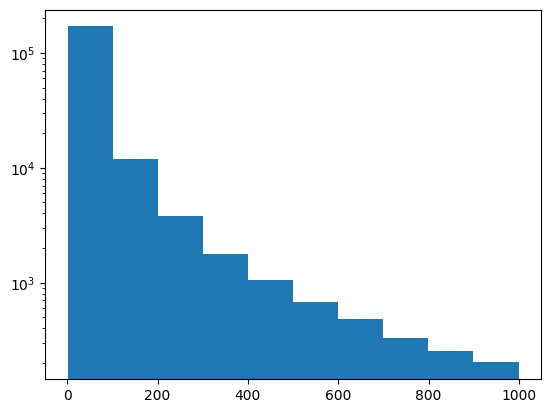

In [9]:
from matplotlib import pyplot as plt

length = np.array(p_length)
length = length[length<1000]

plt.hist(length, log=True)

(array([101951.,  36596.,  16051.,   9206.,   5952.,   4465.,   2873.,
          2110.,   1637.,   1348.]),
 array([  1. ,  20.8,  40.6,  60.4,  80.2, 100. , 119.8, 139.6, 159.4,
        179.2, 199. ]),
 <BarContainer object of 10 artists>)

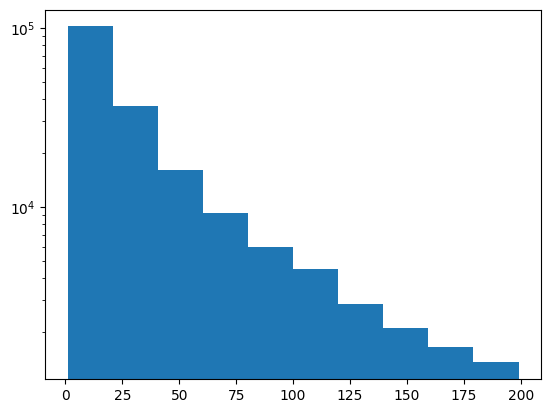

In [10]:
length = np.array(p_length)
length = length[length<200]

plt.hist(length, log=True)

# 確認

In [2]:
from collections import defaultdict
import pandas as pd

In [3]:
with open('./variances.tsv', mode = 'r') as f:
    lines = f.readlines()

data = defaultdict(lambda : dict())
for i, line in enumerate(lines):
    line = line.split('\t')
    if len(line) != 6:
        print(i)
    p_id, pid, pl_var, p_c, sq_var, s_c = line
    if p_id != pid:
        print(p_id)
    
    data[int(p_id)]['pl_var'] = float(pl_var)
    data[int(p_id)]['sq_var'] = float(sq_var) 
    if float(pl_var) > 0:
        data[int(p_id)]['coherence'] = 1.0 - float(sq_var) /float(pl_var)
    else:
        data[int(p_id)]['coherence'] = 0.0

In [10]:
for id, values in list(data.items())[:10]:
    print(id,' : ',values)

0  :  {'pl_var': 0.37967652, 'sq_var': 0.3737031, 'coherence': 0.01573291917024522}
1  :  {'pl_var': 0.4306542, 'sq_var': 0.42670858, 'coherence': 0.009161921560268071}
2  :  {'pl_var': 0.0, 'sq_var': 0.0, 'coherence': 0.0}
3  :  {'pl_var': 0.0, 'sq_var': 0.0, 'coherence': 0.0}
4  :  {'pl_var': 0.4450305, 'sq_var': 0.41661507, 'coherence': 0.06385052260463053}
5  :  {'pl_var': 0.31793073, 'sq_var': 0.2891224, 'coherence': 0.0906119707270826}
6  :  {'pl_var': 0.009731254, 'sq_var': 0.009839386, 'coherence': -0.011111825875678605}
7  :  {'pl_var': 0.36295888, 'sq_var': 0.33043468, 'coherence': 0.0896084978000814}
8  :  {'pl_var': 0.2845856, 'sq_var': 0.25909987, 'coherence': 0.08955382844388471}
9  :  {'pl_var': 0.46744153, 'sq_var': 0.45256898, 'coherence': 0.03181692050340501}


In [8]:
with open('./variances.tsv', mode = 'r') as f:
    lines = f.readlines()

data = defaultdict(list)
for i, line in enumerate(lines):
    line = line.split('\t')
    if len(line) != 6:
        print(i)
    p_id, pid, pl_var, p_c, sq_var, s_c = line
    if p_id != pid:
        print(p_id)
    
    if float(pl_var) > 0:
        data['id'].append(int(p_id))
        data['pl_var'].append(float(pl_var))
        data['sq_var'].append(float(sq_var))
        data['coherence'].append(1.0 - float(sq_var) /float(pl_var))
    # else:
    #     data['coherence'].append(0.0)

df = pd.DataFrame.from_dict(data)

In [14]:
df[:10]

,id,pl_var,sq_var,coherence
0,0,0.379677,0.373703,0.015733
1,1,0.430654,0.426709,0.009162
2,4,0.445030,0.416615,0.063851
3,5,0.317931,0.289122,0.090612
4,6,0.009731,0.009839,-0.011112
5,7,0.362959,0.330435,0.089608
6,8,0.284586,0.259100,0.089554
7,9,0.467442,0.452569,0.031817
8,10,0.469342,0.433529,0.076305
9,12,0.467534,0.462543,0.010675


In [9]:
df.sort_values('coherence')

,id,pl_var,sq_var,coherence
71947,125878,7.401487e-17,2.368476e-16,-2.200000
108822,187101,9.841702e-03,2.589826e-02,-1.631482
85158,147680,1.129526e-02,2.829675e-02,-1.505189
90902,157488,5.075305e-17,1.268826e-16,-1.500000
46275,82364,2.400482e-17,4.934325e-17,-1.055556
...,...,...,...,...
31107,56178,2.653641e-01,7.049718e-03,0.973434
94287,163235,1.278431e-01,2.642991e-03,0.979326
76061,132714,4.506614e-17,0.000000e+00,1.000000
35828,64714,2.732857e-16,0.000000e+00,1.000000


In [10]:
df = df.sort_values('pl_var')
df[ df['pl_var'] > 10e-6 ]

,id,pl_var,sq_var,coherence
6857,12473,0.000011,0.000012,-0.157895
58648,103720,0.000012,0.000012,0.050902
42146,75513,0.000013,0.000010,0.250000
81969,142215,0.000014,0.000011,0.179488
111514,191526,0.000015,0.000017,-0.083333
...,...,...,...,...
69598,122024,0.494841,0.494841,0.000000
28296,51447,0.494998,0.494998,0.000000
53556,94957,0.495336,0.495336,0.000000
26222,47731,0.495515,0.495515,0.000000
